## python-rdm

The [python-rdm](https://pypi.org/project/python-rdm/) package is a collection of wrappers for relational data mining algorithmss that aims to make them easy accessible. The input to the algorithms can be read from a relational database (MySQL, PostgreSQL, and SQLite are supported) or from plain CSV text files (with two additional header rows). The following packages are required to run this notebook:

- python-rdm==0.3.5

Additionally, YAP prolog is required for this notebook. Specifically, [YAP version 6.3.3](https://github.com/vscosta/yap-6.3/archive/yap-6.3.3.zip) is known to work; other version may or may not work due to internal changes in YAP.

We demonstrate the `python-rdm` by connecting to a remote relational database, reading data, running a selected relational data mining algorithm and presenting the results. We start by importing the relevant parts of `python-rdm` and establishing a connection to a remote MySQL database where a copy of the Michalski's East-West trains challenge dataset is stored. Keep in mind that in order for this remote connection to work the port 3306 must be open as it is used by MySQL for communication.

In [1]:
from rdm.db import DBContext, DBVendor, DBConnection
connection = DBConnection(
    'ilp',                # User
    'ilp123',             # Password
    'workflow.ijs.si',    # Host
    'trains',             # Database
    vendor=DBVendor.MySQL # Database type
)

The next step is to define the learning context. The target table is _trains_ and the target attribute is _direction_.

In [2]:
context = DBContext(connection, 
                    target_table='trains',
                    target_att='direction')

`DBContext` reads the data, parses column types, foreign keys etc. and loads the data into the `Orange.data.Table` object, stored in memory. Attributes such as `id` are stored as meta attributes. We print out all tables, their domains and first 5 instances.

In [3]:
for table in context.tables:
    print('Table: "{}"'.format(table))
    print('Domain: {}'.format(context.orng_tables[table].domain))
    print(context.orng_tables[table][:5])
    print('')

Table: "cars"
Domain: [position, shape, len, sides, roof, wheels, load_shape, load_num] {id, tid}
[[1, rectangle, short, not_double, none, 2, circle, 1] {1, 1},
 [2, rectangle, long, not_double, none, 3, hexagon, 1] {2, 1},
 [3, rectangle, short, not_double, peaked, 2, triangle, 1] {3, 1},
 [4, rectangle, long, not_double, none, 2, rectangle, 3] {4, 1},
 [1, rectangle, short, not_double, flat, 2, circle, 2] {5, 2}]

Table: "trains"
Domain: [ | direction] {id}
[[ | east] {1},
 [ | east] {2},
 [ | east] {3},
 [ | east] {4},
 [ | east] {5}]



We run the RSD learner. First, we create an `RSDConverter` instance which transforms the data into a form appropriate for RSD (Prolog clauses). RSD supports the following parameters which control feature construction process:

- clauselength
- depth
- negation
- min_coverage
- filtering

We set the maxim length of a feature body to 6, run RSD and display the first 10 induced features.

In [4]:
from rdm.db.converters import RSDConverter
from rdm.wrappers import RSD
from pprint import pprint

conv = RSDConverter(context)
rsd = RSD()
rsd.set('clauselength', 6)

features, arff, _ = rsd.induce(conv.background_knowledge(),
                                   examples=conv.all_examples(),
                                   cn2sd=False)
pprint(features.split('\n')[:10])

['f(1,A):-trains_has_cars(A,B),cars_position(B,4).',
 'f(2,A):-trains_has_cars(A,B),cars_position(B,3).',
 'f(3,A):-trains_has_cars(A,B),cars_position(B,2),cars_shape(B,u_shaped).',
 'f(4,A):-trains_has_cars(A,B),cars_position(B,1),cars_shape(B,rectangle).',
 'f(5,A):-trains_has_cars(A,B),cars_position(B,4),cars_shape(B,u_shaped).',
 'f(6,A):-trains_has_cars(A,B),cars_position(B,3),cars_shape(B,rectangle).',
 'f(7,A):-trains_has_cars(A,B),cars_position(B,2),cars_shape(B,rectangle).',
 'f(8,A):-trains_has_cars(A,B),cars_position(B,1),cars_shape(B,u_shaped).',
 'f(9,A):-trains_has_cars(A,B),cars_position(B,4),cars_shape(B,rectangle).',
 'f(10,A):-trains_has_cars(A,B),cars_position(B,1),cars_shape(B,bucket).']


The generated ARFF file can be loaded into the `Table` structure of Orange data mining suite. `Table` is a wrapper around Numpy arrays and can be used with `scikit-learn` data mining library.

In [5]:
from rdm.helpers import arff_to_orange_table
table = arff_to_orange_table(arff)
print(table.X.shape)
print(table.Y.shape)
print(table.domain)

(20, 135)
(20,)
[f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20, f21, f22, f23, f24, f25, f26, f27, f28, f29, f30, f31, f32, f33, f34, f35, f36, f37, f38, f39, f40, f41, f42, f43, f44, f45, f46, f47, f48, f49, f50, f51, f52, f53, f54, f55, f56, f57, f58, f59, f60, f61, f62, f63, f64, f65, f66, f67, f68, f69, f70, f71, f72, f73, f74, f75, f76, f77, f78, f79, f80, f81, f82, f83, f84, f85, f86, f87, f88, f89, f90, f91, f92, f93, f94, f95, f96, f97, f98, f99, f100, f101, f102, f103, f104, f105, f106, f107, f108, f109, f110, f111, f112, f113, f114, f115, f116, f117, f118, f119, f120, f121, f122, f123, f124, f125, f126, f127, f128, f129, f130, f131, f132, f133, f134, f135 | class]


Finally, we select 20 best features and build a simple decision tree.

In [6]:
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

estimator = SVC(kernel='linear')
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(table.X, table.Y)
X1 = table.X[:,selector.support_]

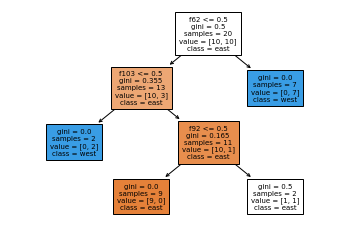

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
tree = DecisionTreeClassifier(min_samples_leaf=2)
tree.fit(X1, table.Y)
y_names = np.array([x.name for x in table.domain.attributes])[selector.support_]
_=plot_tree(tree, 
            feature_names=y_names, 
            filled=True, 
            fontsize=7, 
            class_names=[table.domain.class_var.str_val(i) for i in [0,1]],
            label='all')

Because feature names are very long we print the tree in textual form to improve its readability.

In [8]:
from sklearn.tree import export_text
names = list(np.array([x.split(':-')[1] for x in features.split('\n') if x])[selector.support_])
tree_rules = export_text(tree, feature_names=names)
print(tree_rules)
for i in [0,1]:
    print('class {}: {}'.format(i, table.domain.class_var.str_val(i)))

|--- trains_has_cars(A,B),cars_position(B,3),cars_load_num(B,1). <= 0.50
|   |--- trains_has_cars(A,B),cars_sides(B,double),cars_load_shape(B,circle). <= 0.50
|   |   |--- class: 1.0
|   |--- trains_has_cars(A,B),cars_sides(B,double),cars_load_shape(B,circle). >  0.50
|   |   |--- trains_has_cars(A,B),cars_len(B,short),cars_load_shape(B,triangle). <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- trains_has_cars(A,B),cars_len(B,short),cars_load_shape(B,triangle). >  0.50
|   |   |   |--- class: 0.0
|--- trains_has_cars(A,B),cars_position(B,3),cars_load_num(B,1). >  0.50
|   |--- class: 1.0

class 0: east
class 1: west
